# Kalman Spread Parameter in Trading

In [1]:
# 0. Imports & I/O ------------------------------------------------------
!pip install polars pykalman
import polars as pl
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [2]:
df = pl.read_parquet("../data/processed/ZNZF_1m.parquet") \
       .sort("ts_event") \
       .with_columns(pl.col("ts_event").alias("dt"))  # easier alias

In [3]:
kf = KalmanFilter(
    transition_matrices      = np.eye(2),
    observation_matrices     = np.array([[df['ZF'][0], 1.0]]),
    transition_covariance    = np.eye(2) * 1e-4,
    observation_covariance   = np.array([[1e-2]]),
    initial_state_mean       = [1.0, 0.0],
    initial_state_covariance = np.eye(2)
)

state = [kf.initial_state_mean]

In [4]:
for a, b in zip(df['ZN'][1:], df['ZF'][1:]):
    H = np.array([[b, 1.0]])
    x_prev = state[-1]
    K = (kf.transition_covariance*2) @ H.T @ \
        np.linalg.inv(H @ (kf.transition_covariance*2) @ H.T + kf.observation_covariance)
    x_new = x_prev + K[:, 0] * (a - H @ x_prev)
    state.append(x_new)

state = np.vstack(state)
df = df.with_columns([
        pl.Series("beta",  state[:,0]),
        pl.Series("alpha", state[:,1]),
        pl.Series("spread", df['ZN'] - state[:,0]*df['ZF'] - state[:,1])
     ])

In [5]:
k = 0.01
mu, var, z = 0.0, 1.0, []
for s in df['spread']:
    mu  = (1-k)*mu  + k*s
    var = (1-k)*var + k*(s-mu)**2
    z.append((s - mu) / np.sqrt(var + 1e-9))
df = df.with_columns(pl.Series("z", z))

In [6]:
ENTRY, EXIT, STOP = 2.0, 0.3, 5.0

spread = df['spread'].to_numpy()
z      = df['z'].to_numpy()

n   = len(spread)
pos = 0                 # +1 long spread, -1 short spread, 0 flat
pnl = np.zeros(n)
age = 0                 # holding period in bars

for i in range(1, n):
    # 1) book PnL for the bar we just lived through with the OLD pos
    pnl[i] = pnl[i-1] + pos * (spread[i] - spread[i-1])

    # 2) decide what to hold for the NEXT bar using z[i] (close of bar i)
    if pos != 0:
        age += 1
        if abs(z[i]) < EXIT or abs(z[i]) > STOP or age > 360:  # 6 hours at 1m
            pos = 0
            age = 0

    if pos == 0 and not np.isnan(z[i]) and abs(z[i]) > ENTRY:
        pos = -int(np.sign(z[i]))   # short when z>0, long when z<0
        age = 0

df = df.with_columns(
    pl.Series("pnl", pnl),
    pl.Series("pos", np.r_[0, np.sign(np.diff(pnl))])  # optional, rough
)


Strategy Sharpe (no costs): 10.09


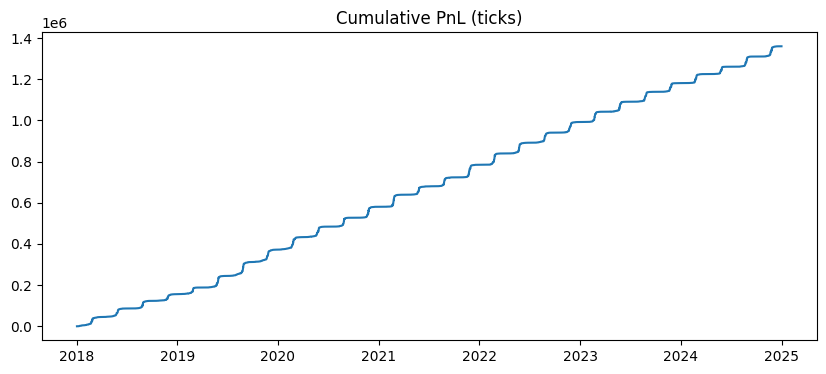

In [7]:
# 4. Quick performance view ---------------------------------------------
ret = np.diff(pnl)
sharpe = np.mean(ret)/np.std(ret) * np.sqrt(252*6.5*12)
print("Strategy Sharpe (no costs):", round(sharpe,2))

plt.figure(figsize=(10,4))
plt.plot(df['dt'], df['pnl'])
plt.title("Cumulative PnL (ticks)")
plt.show()